### Utils

In [84]:
import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import cv2

from glob import glob
from os import path as pathlib
from tqdm.cli import tqdm

In [440]:
PATH = pathlib.abspath("./datasets/BCCD/")
IMG_SIZE = 384

In [441]:
class VOCParserFromDirectory(object):
    """
    Pascal VOC parser for dataset object.
    """
    def __init__(self,path:str,img_size:int):
        self.path = path
        self.data = []
        self.img_size = img_size
        self.repr = f"Dataset @ {self.path}"

    def __repr__(self):
        return self.repr
        
    def __len__(self,):
        return self.length
        
    def parse(self,bar=True):    
        for p in tqdm(glob(pathlib.abspath(f"{self.path}/annotations/*.xml")),desc="Reading XML   "):
            try:
                parse = ET.parse(p)
            except:
                continue
            objects = [[i.tag,i.text] for i in parse.iter()]
            image = {i:j for i ,j in objects[:11]}
            boxes = []
            for ob,name,pose,_,__,___,xmin,ymin,xmax,ymax in np.array(objects[11:]).reshape(-1,20)[:,1::2]:
                boxes.append(dict(
                    name=name,
                    xmin=int(self.img_size*int(xmin)/int(image['width'])),
                    ymin=int(self.img_size*int(ymin)/int(image['height'])),
                    xmax=int(self.img_size*int(xmax)/int(image['width'])),
                    ymax=int(self.img_size*int(ymax)/int(image['height'])),
                ))    
            image['boxes'] = boxes
            image['filename'] = pathlib.abspath(f"{self.path}/images/{image['filename']}")
            [image.pop(i) for i in ['annotation','path','folder','source','size','database','segmented','depth']];
            self.data.append(image)
        self.images = np.array([
                    cv2.cvtColor(cv2.resize(cv2.imread(i['filename']),(IMG_SIZE,IMG_SIZE)),cv2.COLOR_BGR2RGB) 
                    for 
                        i 
                    in 
                        tqdm(self.data,desc="Reading Images")
                ])
        self.length = len(self.data)
        
    def generate_enchors(self,anchors):
        self.prob,self.box = anchors.encode_batch(self.data,bar=True)
        
    def get_split(self,length:int,test_size):
        test = test_size if isinstance(length,int) else int(test_size*length)
        train_index = np.arange(0,length)
        test_index = set(np.random.choice(train_index,test,replace=False))
        train_index = set(train_index)    
        train_index = list(train_index.difference(test_index))
        test_index = list(test_index)
        return train_index,test_index

    def flow(self,epochs:int,batch_size:int,index:list,br:int):
        for epoch in range(epochs):
            index = index.reshape(-1)
            np.random.shuffle(index)
            if br:
                index_ = index[:-br].reshape(-1,batch_size) 
                for i in index_:
                    yield self.images[i] ,(self.prob[i],self.box[i])
                yield self.images[-br:] ,(self.prob[-br:],self.box[-br:])
            else:
                index_ = index.reshape(-1,batch_size) 
                for i in index_:
                    yield self.images[i] ,(self.prob[i],self.box[i])
                    
    def get_flow(self,epochs:int,batch_size:int,index:list=None):
        if not index:
            index = np.arange(0,self.length)
        index = np.array(index)
        br = self.length%batch_size
        
        flow = self.flow(epochs,batch_size,index,br)
        steps_per_epochs = int(br != 0) + (self.length // batch_size)
        return flow,steps_per_epochs

In [442]:
dataset = VOCParserFromDirectory(path=PATH,img_size=IMG_SIZE)

In [443]:
dataset.parse()

Reading Images: 100%|██████████| 363/363 [00:01<00:00, 253.10it/s]


### Anchors

In [444]:
from collections import Counter

In [445]:
class BoxGrid(object):
    """
    Encodes Box
    """
    def __init__(self,low,high):
        self.low = low
        self.high = high
        self.repr = f"""
BoxGrid(
    low={self.low},
    high={self.high}
)
        """
    
    def __repr__(self):
        return self.repr
    
    def encode(self,h,w):
        return h/self.high,w/self.high
    
    def get_pair(self,y,x,h,w):
        h = int(h*self.high)
        w = int(w*self.high)
        return (x - (h//2),y - (h//2)),(x + (h//2),y + (h//2))
    
    def decode(self,):
        pass
    
    def encodeBatch(self,):
        pass
    
    def decodeBatch(self,):
        pass

In [446]:
class AnchorGrid(object):
    
    def __init__(self,resize_factor,k,image_size,box_gen,classes,n_classes):
        
        self.k = k
        self.classes = classes
        self.n_classes = n_classes
        self.resize_factor = resize_factor
        self.image_size = image_size
        self.grid_size = image_size // resize_factor
        self.box_gen = BoxGrid(**box_gen)
        self.length = self.grid_size*self.grid_size*self.k
        self.class_prob = np.zeros((self.n_classes+1))
        
        
        self.repr = f"""
AnchorGrid (
    resize_factor={self.resize_factor},
    k={self.k},
    image_size={self.image_size},
    grid_size={self.grid_size}
)"""
        self.ignored = []
        
    def __repr__(self,):
        return self.repr
                
    def __call__(self,data):
        """
        Returns : encoded_prob,encoded_box
        """
        box = np.zeros((self.grid_size,self.grid_size,self.k,4))
        prob_0 = np.zeros((self.grid_size,self.grid_size,self.k,self.n_classes))
        prob_1 = np.ones((self.grid_size,self.grid_size,self.k,1))
        prob = np.concatenate((prob_1,prob_0),axis=3)        
        
        data = data[np.logical_and(np.all(data[:,3:] <= self.box_gen.high,axis=1), np.any(data[:,3:] > self.box_gen.low,axis=1))]
        _counter = Counter()

        for cls,y,x,h,w in data:
            Ox = int(x // self.resize_factor) 
            Oy = int(y // self.resize_factor) 
            if Ox >= self.grid_size or Oy >= self.grid_size:
                continue

            x = (x - (Ox*self.resize_factor)) / self.resize_factor
            y = (y - (Oy*self.resize_factor)) / self.resize_factor
            h,w = self.box_gen.encode(h,w)
            Oi = _counter[f"{Oy}x{Ox}"]
            
            if Oi >= self.k:
                self.ignored.append(data)
                continue
            
            class_prob = self.class_prob.copy()
            class_prob[self.classes.index(cls)+1] = 1
            box[Oy,Ox,Oi,:] = [y,x,h,w]
            prob[Oy,Ox,Oi,:] = class_prob
            
            _counter[f"{Oy}x{Ox}"] += 1

        prob,box =  prob.reshape(-1,self.k,self.n_classes+1),box.reshape(-1,self.k,4)
        return prob.reshape(-1,self.n_classes+1),box.reshape(-1,4)
    
    def encode(self,data):
        return self.__call__(data)
    
    def decode(self,prob,boxes,thresh=0.9):
        prob = prob.reshape(-1,self.k,self.n_classes+1).reshape(self.grid_size,self.grid_size,self.k,self.n_classes+1).copy()
        boxes = boxes.reshape(-1,self.k,4).reshape(self.grid_size,self.grid_size,self.k,4).copy() 
        boxes[:,:,:,:2] = ((boxes[:,:,:,:2] * self.resize_factor) + self.grid_decode).astype(int) - (self.resize_factor // 2)
        
        prob = prob.reshape(-1,4)
        classes = prob.argmax(axis=-1)
        mask = classes > 0
        
        scores = prob.max(axis=-1)[mask]
        boxes = boxes.reshape(-1,4)[mask]
        classes = classes[mask]
        
        boxes[:,2:] = boxes[:,2:] * self.box_gen.high
        return classes.astype(int),scores.astype(float),boxes.astype(int)
        
    def generate(self,ret=False):
        xx,yy = np.meshgrid(np.arange(self.grid_size),np.arange(self.grid_size))
        xx,yy = np.reshape(xx,(self.grid_size,self.grid_size,1)),np.reshape(yy,(self.grid_size,self.grid_size,1))
        self.reference = np.concatenate((yy,xx),axis=-1)
        self.grid = self.reference.copy() * self.resize_factor
        self.grid += self.resize_factor // 2
        self.grid_decode = self.grid.copy().reshape(self.grid_size,self.grid_size,1,2).repeat(self.k,axis=2)
        if ret:
            return self.grid.copy(),self.reference.copy()

    def plot_grid(self,img,axes,prob,boxes):
        prob = prob.reshape(-1,self.k,self.n_classes+1).reshape(self.grid_size,self.grid_size,self.k,self.n_classes+1).copy()
        boxes = boxes.reshape(-1,self.k,4).reshape(self.grid_size,self.grid_size,self.k,4).copy()
        boxes[:,:,:,:2] = ((boxes[:,:,:,:2] * self.resize_factor) + self.grid_decode).astype(int) - (self.resize_factor // 2)
        
        for ba,pa,(y,x) in zip(boxes.reshape(-1,self.k,4),prob.reshape(-1,self.k,self.n_classes+1),self.grid.reshape(-1,2)):
            img = cv2.circle(img,(x,y),2,(255,255,0),-1)
            img = cv2.rectangle(
                        img,
                        (x-(self.resize_factor//2),y-(self.resize_factor//2)),
                        (x+(self.resize_factor//2),y+(self.resize_factor//2)),
                        (255,255,0),
                        1
                    )
            for (y,x,h,w),p in zip(ba,pa):
                p_ = p.argmax()
                if p_ > 0:
                    xmin = int(x - (w*self.box_gen.high//2))
                    ymin = int(y - (h*self.box_gen.high//2))
                    xmax = int(x + (w*self.box_gen.high//2))
                    ymax = int(y + (h*self.box_gen.high//2))
                    img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),1)
                    img = cv2.putText(
                            img,
                            self.classes[p.argmax()-1],
                            (xmin+3,ymin+8),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.3,
                            (250,250,250)
                        )
            
        axes.imshow(img)

In [447]:
class Anchors(object):
    """
    Encode Various Sizes Of FPNS
    """
    
    def __init__(self,img_size,classes,config,):
        self.img_size = img_size
        self.config = config
        self.classes = classes
        self.n_classes = len(classes)
        
        for cfg in config:
            self.__dict__[f"ANCHOR_{cfg['name']}"] = AnchorGrid(**cfg['anchor_grid'],classes=classes,n_classes=self.n_classes)
            self.__dict__[f"ANCHOR_{cfg['name']}"].generate()
        
        self.ANCHORS = [i for (i,j) in self.__dict__.items() if "ANCHOR_" in i]
        
        self.skipped = []
        
    def __repr__(self,):
        return self.config.__repr__()
    
    def __call__(self,data:dict,conc:bool=True):
        """
        Returns : encoded_prob,encoded_box
        """
        boxt = pd.DataFrame(data)
        boxt['h'] = boxt.ymax - boxt.ymin
        boxt['w'] = boxt.xmax - boxt.xmin

        boxt['y'] = boxt.ymin + ( boxt.h // 2 )
        boxt['x'] = boxt.xmin + ( boxt.w // 2 )
        
        boxt = boxt[['name','y','x','h','w']].sort_values(by=['y','x','h','w']).values
        prob,box = [],[]
        
        for anchor in self.ANCHORS:
            p,b = self.__dict__[anchor](boxt)
            prob.append(p)
            box.append(b)
            
        if conc:
            prob = np.concatenate(prob,axis=0)
            box = np.concatenate(box,axis=0)
            return prob,box
        
        return prob,box
    
    def encode(self,data,conc:bool=True):
        return self.__call__(data,conc=conc)
    
    def encode_batch(self,data,bar=False,conc:bool=True):
        prob,boxes = [],[]
        for i,d in enumerate(tqdm(data) if bar else data):
            p,b = self.__call__(d['boxes'],conc=conc)
            prob.append(p)
            boxes.append(b)                
        return np.array(prob),np.array(boxes)
    
    def decode(self,prob,boxes,thresh=0.9):
        """
        Returns Classes,Scores,Boxes
        """
        prob = prob.reshape(-1,self.n_classes + 1)
        boxes = boxes.reshape(-1,4)
        
        last = 0
        ret_boxes = []
        ret_scores = []
        ret_classes = []
        for anchor in self.ANCHORS:
            index = self.__dict__[anchor].length
            batch_ = (prob[last:last+index].copy(),boxes[last:last+index].copy())
            C,S,B = self.__dict__[anchor].decode(*batch_,thresh=thresh)
            last = last+index
            ret_scores.append(S)
            ret_boxes.append(B)
            ret_classes.append(C)
                       
        return (
                np.concatenate(ret_classes,axis=0).astype(np.int32),
                np.concatenate(ret_scores,axis=0).astype(np.float32),
                np.concatenate(ret_boxes,axis=0).astype(np.int32)
               )

    def plot_grid(self,img,prob,boxes):
        img = cv2.resize(img.copy(),(self.img_size,self.img_size))
        fig,axes = plt.subplots(len(self.ANCHORS),1,figsize=(14,14*len(self.ANCHORS)))
                
        prob = prob.reshape(-1,self.n_classes+1)
        boxes = boxes.reshape(-1,4)
        
        last = 0
        for anchor,ax in zip(self.ANCHORS,axes):
            index = self.__dict__[anchor].length
            batch = (prob[last:last+index].copy(),boxes[last:last+index].copy())
            self.__dict__[anchor].plot_grid(img.copy(),ax,*batch)
            last = last+index

In [448]:
anchor_config = {
    "img_size":IMG_SIZE,
    "classes":['RBC','WBC','Platelets'],
    "config":[
        {
                'anchor_grid': {
                    'resize_factor': 32, 
                    'k': 6, 
                    'image_size': IMG_SIZE, 
                    'box_gen': {
                        'low': 2, 
                        'high': 224
                    }
                }, 
            'name': 'FPN'
        },
    ]
}

In [449]:
anchors = Anchors(**anchor_config)

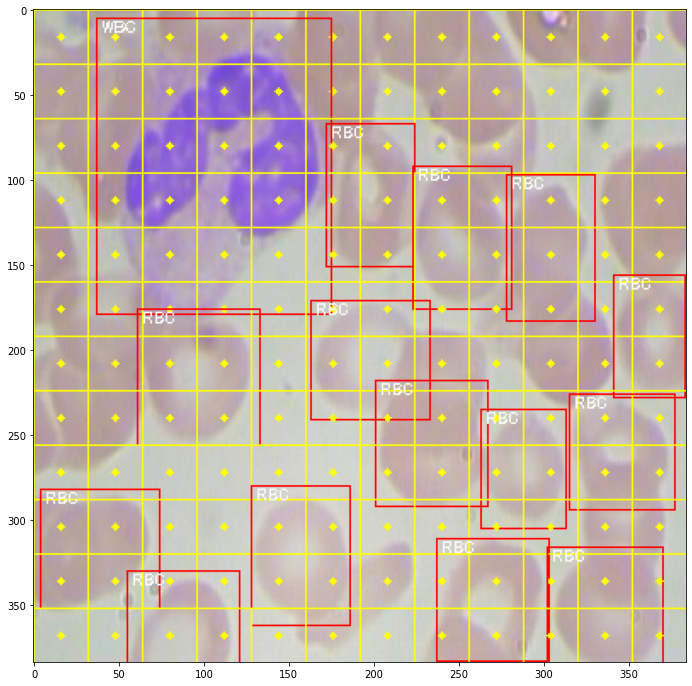

In [450]:
i = np.random.randint(0,len(dataset.images))
img = dataset.images[i].copy()

fig,axes = plt.subplots(1,1,figsize=(12,12))
p,b = anchors.encode(dataset.data[i]['boxes'])
anchors.ANCHOR_FPN.plot_grid(img,axes,p,b)

In [451]:
dataset.generate_enchors(anchors)

100%|██████████| 363/363 [00:02<00:00, 122.07it/s]


### Net

In [452]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import ( Input,Conv2D,MaxPool2D,
                                     Activation,Reshape,
                                     BatchNormalization,Dense,
                                     LeakyReLU,concatenate,
                                    )
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,Callback

In [453]:
K = 6

In [454]:
def proposals(_in,ksize,k,name):
    prob = Conv2D(k*4,ksize,padding="same",name=f"prob_conv_{name}",kernel_initializer="ones",use_bias=False)(_in)
    prob = BatchNormalization(name=f"prob_norm_{name}")(prob)
    prob = Activation("sigmoid",name=f"prob_out_{name}")(prob)
    prob = Reshape((-1,4),name=f"{name}_prob")(prob)

    box = Conv2D(k*4,ksize,padding="same",name=f"box_conv_{name}",kernel_initializer="ones",use_bias=False)(_in)
    box = BatchNormalization(name=f"box_batch_{name}")(box)
    box = Activation("sigmoid",name=f"box_out_{name}")(box)
    box = Reshape((-1,4),name=f"{name}_box")(box)
    
    return prob,box


_in = keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
net = keras.applications.MobileNet(include_top=False,input_tensor=_in,weights="imagenet")

feat = net.output
feat = Dense(1024)(feat)
feat = LeakyReLU(0.1)(feat)
prob,box = proposals(feat,1,K,"p")

model = keras.Model(_in,[prob,box])

In [455]:
class BoxLoss(tf.Module):
    """
    BoxLoss
    """
    def __init__(self,):
        self.__name__="BoxLoss"
        self.zero = tf.constant(0,tf.float32)
        self.one = tf.constant(1,tf.float32)
        self.two = tf.constant(2,tf.float32)
        self.l2_loss = tf.keras.losses.MeanSquaredError()
        self.l1_loss = tf.keras.losses.MeanAbsoluteError()

        self.slice_y = {"begin":[0,0,0],"size":[-1,-1,1]}
        self.slice_x = {"begin":[0,0,1],"size":[-1,-1,1]}
        self.slice_h = {"begin":[0,0,2],"size":[-1,-1,1]}
        self.slice_w = {"begin":[0,0,3],"size":[-1,-1,1]}
        
        self.repr = f"""BoxLoss()"""
        
    def __repr__(self,):
        return self.repr

    
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        y = tf.slice(y_true,**self.slice_y)
        x = tf.slice(y_true,**self.slice_x)
        mask = tf.logical_or(tf.greater(y,self.zero),tf.greater(x,self.zero))
        y = y[mask] 
        x = x[mask] 
        h = tf.slice(y_true,**self.slice_h)[mask] 
        w = tf.slice(y_true,**self.slice_w)[mask] 
        y_ = tf.slice(y_pred,**self.slice_y)[mask] 
        x_ = tf.slice(y_pred,**self.slice_x)[mask] 
        h_ = tf.slice(y_pred,**self.slice_h)[mask] 
        w_ = tf.slice(y_pred,**self.slice_w)[mask] 
        loss = self.l2_loss(x,x_) + self.l2_loss(y,y_) + self.l1_loss(h,h_) + self.l1_loss(w,w_)
        if tf.math.is_nan(loss):
            return self.zero
        return loss

In [456]:
loss = BoxLoss()
opt = keras.optimizers.Nadam(learning_rate=0.001-0.00001,beta_1=0.9,beta_2=0.997,epsilon=1e-8)

model.compile(optimizer=opt,loss={
    "p_prob":tf.losses.BinaryCrossentropy(),
    "p_box":loss,
})

In [457]:
EPOCHS = 1
BATCH_SIZE = 3

In [458]:
flow,steps_per_epochs = dataset.get_flow(EPOCHS,BATCH_SIZE)

In [ ]:
model.fit_generator(flow,steps_per_epoch=steps_per_epochs,epochs=EPOCHS)

 21/121 [====>.........................] - ETA: 6s - loss: 1.2446 - p_prob_loss: 0.7909 - p_box_loss: 0.4537

In [429]:
def IoU(y,x,h,w,box):
    dist = np.sqrt(np.square(y - box[:,0]) + np.square(x - box[:,1]))
    closest = dist.argsort()[1]
    y_,x_,h_,w_ = boxes[closest].copy()
    xmin = x - (w//2)
    ymin = y - (h//2)
    xmax = x + (w//2)
    ymax = y + (h//2)
    xmin_ = x_ - (w_//2)
    ymin_ = y_ - (h_//2)
    xmax_ = x_ + (w_//2)
    ymax_ = y_ + (h_//2)

    Ch = min(ymax,ymax_) - max(ymin,ymin_)
    Cw = min(xmax,xmax_) - max(xmin,xmin_)

    Aa = h  * w
    Ba = h_ * w_
    Ca = Ch * Cw
    IoU = (Ca)/(Aa + Ba - Ca)
    return IoU,closest,dist[closest]

def suppress(classes,scores,boxes,thresh=0.45):
    skip = []
    newboxes = []
    newscores = []
    newclasses = []
    for j,(s,c,(y,x,h,w)) in enumerate(zip(scores,classes,boxes)):
        if j not in skip:
            iou,cls,dist = IoU(y,x,h,w,boxes.copy())
            if iou > thresh:
                skip.append(cls)
            newboxes.append([y,x,h,w])
            newscores.append(s)
            newclasses.append(c)
            
    return np.array(newclasses),np.array(newscores),np.array(newboxes)

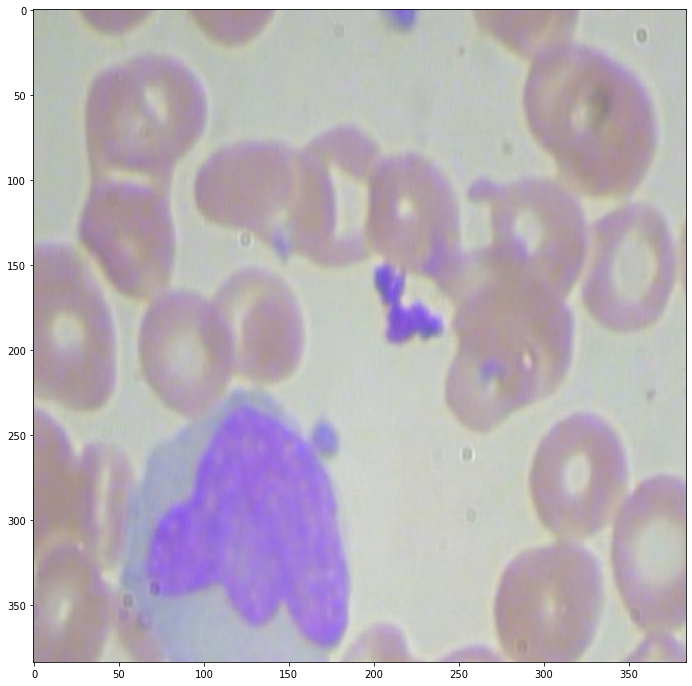

In [430]:
i = np.random.choice(t)
img = dataset.images[i].copy()
p,b = model.predict(np.expand_dims(img,0))
classes,scores,boxes = anchors.decode(p,b)
classes,scores,boxes = suppress(classes,scores,boxes)

for C,S,(y,x,h,w) in zip(classes,scores,boxes):
    xmin = x - (w//2)
    ymin = y - (h//2)
    xmax = x + (w//2)
    ymax = y + (h//2)    
    img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(250,10,10),1)
    img = cv2.circle(img,(x,y),2,(250,10,10),-1)
    img = cv2.putText(
                        img,
                        f"{anchors.classes[C-1]}-{str(S)[:5]}",
                        (xmin+3,ymin+8),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.3,
                        (250,250,250)
                    )
    
plt.figure(figsize=(12,12))
plt.imshow(img)